# PyTorch を利用した実装

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/hseiyama/DeepLearning/blob/main/pytorch_basic_01_layer.ipynb)

In [40]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

### パラメータの定義

In [41]:
epoch_num = 20  # エポック数を設定する
batch_size = 100  # バッチの数
learning_rate = 0.1  # 学習係数

### MNIST データセット

In [42]:
# 訓練データをdatasetsからダウンロード
training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

# テストデータをdatasetsからダウンロード
test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

### データローダー

In [43]:
# データローダーの作成
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print('X.shape [N, C, H, W]:', X.shape)
    print('y.shape:', y.shape, y.dtype)
    break

X.shape [N, C, H, W]: torch.Size([100, 1, 28, 28])
y.shape: torch.Size([100]) torch.int64


#### 【オプション】入力データの確認

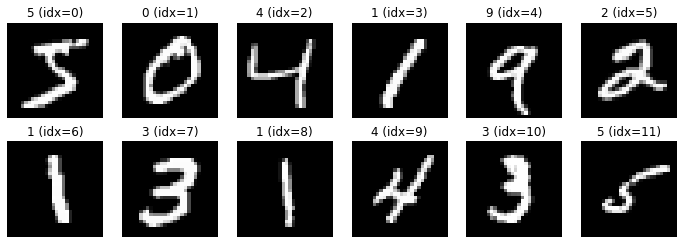

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5])


In [44]:
for X, y in train_dataloader:
    x_train = X
    t_train = y
    break

# 画像を表示
figure = plt.figure(figsize=(12, 4))
rows, cols = 2, 6
for i in range(rows * cols):
    img, label = x_train[i], t_train[i]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'{label} (idx={i})')
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')  # 1x28x28 -> 28x28 に変換
plt.show()
print(y[:rows * cols])

### ニューラルネットワークの定義

In [45]:
# modelを定義します
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()  # (batch)x1x28x28 -> (batch)x(28*28) に変換
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 50),  # 全結合層 (batch)x(28*28) -> (batch)x50
            #nn.Sigmoid(),
            nn.ReLU(),
            nn.Linear(50, 10)  # 全結合層 (batch)x50 -> (batch)x10
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

### ニューラルネットワークのインスタンス化

In [46]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


### 損失関数と最適化手法を定義

In [47]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### 訓練のプロセス

In [48]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # 訓練モード
    loss_list = []
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        #y = torch.eye(10)[y]  # index -> one-hot 形式に変換
        
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        print(f'\rtrain batch({batch + 1})', end='')
    
    return loss_list

### 評価のプロセス

In [49]:
def test(dataloader, model, title):
    model.eval()  # 評価モード
    correct = 0
    size = len(dataloader.dataset)
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            print(f'\rtest({title}) batch({batch + 1}){" " * 5}', end='')
    correct /= size
    
    return correct

### ミニバッチの学習

In [50]:
train_loss_list = []
train_acc_list = [0.0]
test_acc_list = [0.0]

for t in range(epoch_num):
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_loss_list += train_loss
    print(f'\repoch({t + 1}) loss = {train_loss_list[-1]}')
    train_acc = test(train_dataloader, model, 'train_data')
    test_acc = test(test_dataloader, model, 'test_data')
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f'\repoch({t + 1}) accuracy(train, test) = ({train_acc}, {test_acc})')

print('Done!')

epoch(1) loss = 0.36792027950286865
epoch(1) accuracy(train, test) = (0.9023166666666667, 0.9085)
epoch(2) loss = 0.330897718667984
epoch(2) accuracy(train, test) = (0.9215333333333333, 0.9234)
epoch(3) loss = 0.29836970567703247
epoch(3) accuracy(train, test) = (0.9351666666666667, 0.9332)
epoch(4) loss = 0.27072781324386597
epoch(4) accuracy(train, test) = (0.9447, 0.9434)
epoch(5) loss = 0.2523236870765686
epoch(5) accuracy(train, test) = (0.95135, 0.949)
epoch(6) loss = 0.2366209626197815
epoch(6) accuracy(train, test) = (0.9569666666666666, 0.9525)
epoch(7) loss = 0.22880619764328003
epoch(7) accuracy(train, test) = (0.96045, 0.9557)
epoch(8) loss = 0.22294148802757263
epoch(8) accuracy(train, test) = (0.9635833333333333, 0.9585)
epoch(9) loss = 0.21800604462623596
epoch(9) accuracy(train, test) = (0.9660333333333333, 0.9603)
epoch(10) loss = 0.21408714354038239
epoch(10) accuracy(train, test) = (0.9686666666666667, 0.9624)
epoch(11) loss = 0.2115103304386139
epoch(11) accuracy(tr

### 損失関数の推移

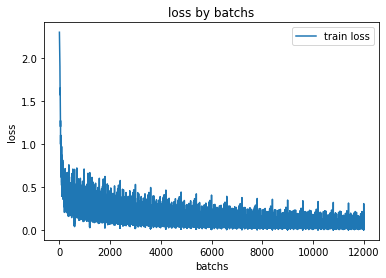

In [51]:
# グラフの描画
x = torch.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss')
plt.xlabel('batchs')
plt.ylabel('loss')
plt.title('loss by batchs')
plt.legend(loc='upper right')
plt.show()

### 認識精度の推移

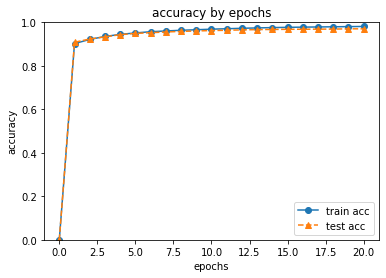

In [52]:
# グラフの描画
x = torch.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc', marker='o')
plt.plot(x, test_acc_list, label='test acc', linestyle='--', marker='^')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy by epochs')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#### 【オプション】テストの結果

In [53]:
x_test = None
t_test = None
test_predict = None

# テストの実行
model.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        X, y, pred = X.to('cpu'), y.to('cpu'), pred.to('cpu')
        x_test = torch.cat((x_test,X),0) if x_test is not None else X
        t_test = torch.cat((t_test,y),0) if t_test is not None else y
        test_predict = torch.cat((test_predict,pred),0) if test_predict is not None else pred

print(test_predict.shape)
for index in range(3):
    print(f'index = {index}')
    print(test_predict[index])
    print(t_test[index])

torch.Size([10000, 10])
index = 0
tensor([ -1.9496,  -2.6722,   3.9225,   6.1410,  -5.7591,  -0.0165, -15.1281,
         12.8737,   1.2758,   2.4548])
tensor(7)
index = 1
tensor([  5.5478,   3.3323,  13.1805,   3.8774, -12.8098,   5.0272,   5.1551,
        -14.4201,   3.9862, -10.1377])
tensor(2)
index = 2
tensor([-4.3526,  8.6404,  2.2747, -0.1267, -0.7647, -1.3050, -1.1796,  2.0610,
         1.7712, -2.3492])
tensor(1)


#### 【オプション】エラー結果の確認

error rate = 2.98[%] (num = 298/10000)


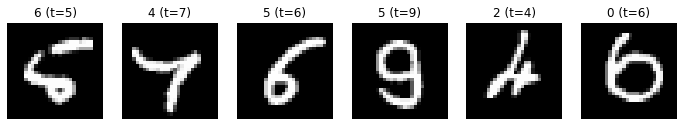

tensor([[ 9.1563e-01, -6.6249e+00,  5.4455e+00, -5.0486e+00,  1.7016e+00,
          5.0513e+00,  8.3884e+00, -1.0714e+01,  2.3505e+00, -3.7950e-01],
        [-6.3526e+00, -6.4992e+00, -1.5937e+00, -1.3206e+00,  1.0331e+01,
         -1.2428e+00, -1.3650e+00,  8.1981e+00,  3.5049e+00,  1.4111e+00],
        [ 2.0955e+00, -1.0314e-01,  1.0927e+00, -4.7858e+00,  5.2940e-01,
          1.0126e+01,  9.9887e+00, -1.6363e+01,  7.3368e+00, -5.7137e+00],
        [ 2.6262e+00, -1.1235e+01, -7.5289e-01,  2.4471e+00, -5.2145e+00,
          6.4447e+00, -3.8745e+00, -4.3119e+00,  3.8093e+00,  6.2463e+00],
        [-1.2193e+00, -1.1464e+00,  7.9564e+00, -5.3240e-01,  3.5636e+00,
          1.8997e-01,  6.5561e+00, -4.5075e+00, -1.4157e-02, -6.9531e+00],
        [ 9.7940e+00, -8.5276e+00,  1.5142e-01, -2.7143e+00, -3.4823e+00,
          4.6928e+00,  7.2765e+00,  8.2859e-01, -7.3201e-01, -6.7714e+00]])


In [54]:
# エラー結果の要素を抽出
index_error = torch.argmax(test_predict, axis=1) != t_test
error_list = torch.arange(len(test_predict))[index_error]
print(f'error rate = {len(error_list) / len(test_predict) * 100}[%]',
      f'(num = {len(error_list)}/{len(test_predict)})')

offset = 0
# 画像を表示
figure = plt.figure(figsize=(12, 2))
rows, cols = 1, 6
for i in range(rows * cols):
    index = error_list[offset + i]
    img, label_t, label_y = x_test[index], t_test[index], test_predict[index].argmax()
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'{label_y} (t={label_t})')
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')  # 1x28x28 -> 28x28 に変換
plt.show()
print(test_predict[error_list[offset:offset + rows * cols]])